# MURA
---

This notebook aims to classify x-ray images as normal or abnormal.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io
from skimage import color
from skimage.transform import resize

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Preprocessing & Exploration
---

We load the MURA **metadata** for training and testing and create a label column:

In [3]:
# read csv and create labels 0: normal 1: abnormal
df_train = pd.read_csv('gdrive/MyDrive/Datasets/MURA-v1.1/train_image_paths.csv', header=None, names=['path'])
df_train[['dataset', 'set', 'body_part', 'patient', 'study', 'image']] = df_train.path.str.split('/', expand=True)
df_train[['_', 'label']] = df_train.study.str.split('_', expand=True)
df_train['label'] = df_train['label'].map({'negative': 0, 'positive': 1})

df_test = pd.read_csv('gdrive/MyDrive/Datasets/MURA-v1.1/valid_image_paths.csv', header=None, names=['path'])
df_test[['dataset', 'set', 'body_part', 'patient', 'study', 'image']] = df_test.path.str.split('/', expand=True)
df_test[['_', 'label']] = df_test.study.str.split('_', expand=True)
df_test['label'] = df_test['label'].map({'negative': 0, 'positive': 1})

The dataset contains images of different body types. Their distribution along with their breakdown regarding normality and abnormality is:

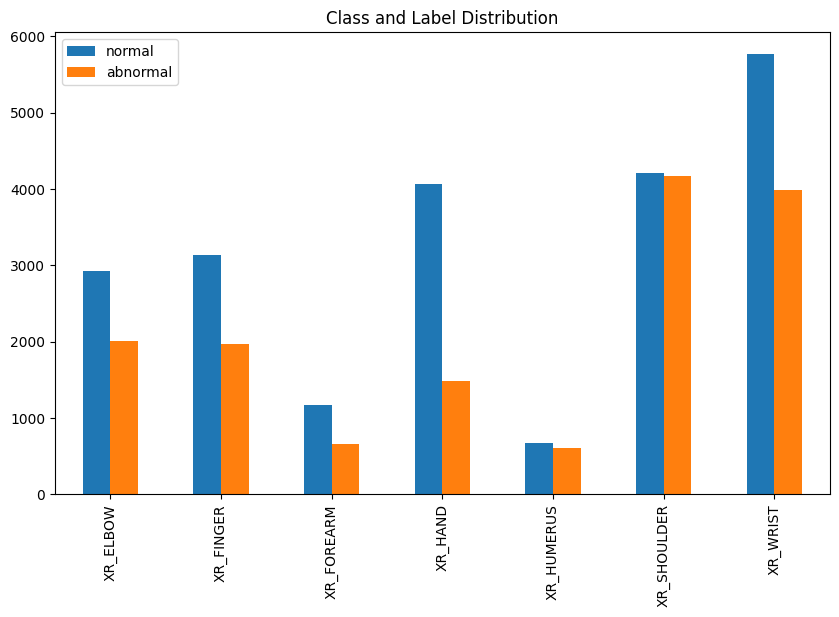

In [4]:
# visualizing class distribution
df_train.groupby(['body_part', 'label']).size().unstack(level=1).plot(
    kind='bar',
    title='Class and Label Distribution',
    figsize = (10, 6)
)
plt.legend(title="", labels=['normal', 'abnormal'])
plt.xlabel("")
plt.show()

Given the size of the dataset, we will only work on **shoulder** images:

In [5]:
# filtering out body parts except shoulder
df_train = df_train[df_train['body_part'].isin(['XR_SHOULDER'])]
df_train = df_train[['path', 'body_part', 'label']]

df_test = df_test[df_test['body_part'].isin(['XR_SHOULDER'])]
df_test = df_test[['path', 'body_part', 'label']]

For loading the images we will the `read_image` function, which loads an image as grayscale and resizes it to *224x224*. The `imread` function that was used returns pixel frames in the range between *0* and *1*, so no further standarization needs to take place. The resizing of the images corresponds to the [transformation](https://arxiv.org/abs/1712.06957) the creators of the dataset followed:

In [6]:
def read_image(path: str, h: int=224, w: int=224) -> list:

    """
    Read and return a (h, w) array of the image from given directory.

    PARAMETERS
        @ path: string of directory
        @ h: height of desired image resize
        @ w: width of desired image resize
        @ color: color space conversion code

    RETURNS
        (h, w) array of image
    """

    img = io.imread(path, as_gray=True)
    img = resize(img, (h, w), anti_aliasing=True)
    return img

We then read solely the shoulder images for training:

In [ ]:
# read train shoulder images
acc = []
for img_path in df_train['path'].tolist():
    img = read_image('gdrive/MyDrive/Datasets/' + str(img_path))
    acc.append(img)
df_train['img'] = acc

df_train.to_pickle('gdrive/MyDrive/Datasets/MURA-v1.1/train_shoulder.pkl')

And testing:

In [ ]:
# read test shoulder images
acc = []
for img_path in df_test['path'].tolist():
    img = read_image('gdrive/MyDrive/Datasets/' + str(img_path))
    acc.append(img)
df_test['img'] = acc

df_test.to_pickle('gdrive/MyDrive/Datasets/MURA-v1.1/test_shoulder.pkl')

We save the DataFrames locally for faster loading times:

In [7]:
# load from local directory
df_train = pd.read_pickle('gdrive/MyDrive/Datasets/MURA-v1.1/train_shoulder.pkl')
df_test = pd.read_pickle('gdrive/MyDrive/Datasets/MURA-v1.1/test_shoulder.pkl')

Last but not least, we finalize the training, validation and testing sets:

In [8]:
# creation of train, validation, test subsets
train_images, train_labels = np.asarray(df_train['img'].tolist()), df_train['label'].to_numpy().reshape((-1, 1))
test_images, test_labels = np.asarray(df_test['img'].tolist()), df_test['label'].to_numpy().reshape((-1, 1))

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print('Train:       X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Validation:  X=%s, y=%s' % (val_images.shape, val_labels.shape))
print('Test:        X=%s, y=%s' % (test_images.shape, test_labels.shape))

Train:       X=(6703, 224, 224), y=(6703, 1)
Validation:  X=(1676, 224, 224), y=(1676, 1)
Test:        X=(563, 224, 224), y=(563, 1)


## Data Pipeline
---

Before proceeding to the model architectures we followed for the given dataset, we will first create certain functions that will optimize our training. These utilize the `tensorflow.keras.Dataset` package.

In [9]:
def _input_fn(x, y, BATCH_SIZE):

  """
    Receives x and y data and transforms them in PrefetchDataset objects.
    The data is shuffled and batched in the specified size.
    tf.data.experimental.AUTOTUNE is used for calculating the size of prefetched data at runtime according to resource heuristics.

    PARAMETERS
        @ X: X training numpy array
        @ y: y training numpy array
        @ BATCH_SIZE: int corresponding to the training batch size

    RETURNS
        PrefetchedDataset object dataset
  """

  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

The `_input_fn` function prepares the data for training. It utilizes the `repeat` and `batch` methods creating batches from the training set. Notice how the `repeat` method duplicates the dataset indefinately, enabling the `batch` method to generate training batches without any errors.

The function receives the images and labels and returns `PrefetchDataset` objects. These are Tensorflow objects that enable faster training, since the model can read the next-to-train batch of data while training the current batch. The batch size corresponds to the number of images that will flow through the network before a back-propagation operation, and hence a fine-tuning of the weights, takes place.

Even though batch size [can significantly alter](https://www.researchgate.net/publication/322408789_Impact_of_Training_Set_Batch_Size_on_the_Performance_of_Convolutional_Neural_Networks_for_Diverse_Datasets) a networks' behavior, this notebook does not explore how differ sizes affect the model performance.

In [10]:
# creation of PrefetchDataset objects
BATCH_SIZE = 64

train_opt =_input_fn(train_images, train_labels, BATCH_SIZE)
val_opt =_input_fn(val_images, val_labels, BATCH_SIZE)
test_opt = _input_fn(test_images, test_labels, BATCH_SIZE)

## Diagnostics Visualization Function
---

We also implement a visualization function for monitoring the training's performance in terms of accuracy and loss and in comparison with the validation set:

In [11]:
def summarize_diagnostics(history):

  """
    Plots training and validation learning curves.
    Two subplots are created, each one of them comparing training/validation loss and accuracy respectively.

    PARAMETERS
        @ history: model history callback

    RETURNS
        a matplot figure consisting of two subplots, one for loss, one for accuracy

  """

  plt.figure(figsize=(8, 8))
  plt.suptitle('Training Curves')
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

## Models
---

The classification of the dataset will be evaluated on two different approaches:
- a Convolutional Neural Network developed from scratch
- transfer learning on pre-trained models

### CNN Architecture
---

The model we are going to develop is inspired by [VGGNet](https://arxiv.org/abs/1409.1556), one of the earliest CNN architectures proposed to solve large image dataset problems. To avoid overfitting, dropout layers were added to the model's architecture, which randomly ignore a subset of layer outputs. The last layer just before the classification layer is set to a `GlobalAveragePooling`; such choice will keep the trainable parameters of the network low, while also participating into creating a standardized model. The output layer is also set to 1 neuron with sigmoid activation, since the problem we are trying to solve is binary.

In terms of data, we utilize the data augmentation technique, following the same transformations the creators of the dataset followed. These are random rotations and horizontal flips:

In [ ]:
# data augmentation
train_images_cnn = train_images.reshape(len(train_images), 224, 224, 1)

datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)

datagen.fit(train_images_cnn)

We train the network for *100* epochs. `EarlyStopping` with `patience=10` is utilized to ensure standarization:

In [ ]:
# architecture
cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)))
cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)))

cnn.add(tf.keras.layers.Dropout(0.10))

cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)))

cnn.add(tf.keras.layers.Dropout(0.15))

cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)))

cnn.add(tf.keras.layers.Dropout(0.20))

cnn.add(tf.keras.layers.GlobalAveragePooling2D())
cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

cnn.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.0001),
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# training
history_cnn = cnn.fit(
    datagen.flow(train_images_cnn, train_labels, batch_size=64),
    validation_data = val_opt,
    epochs = 100,
    batch_size = BATCH_SIZE,
    steps_per_epoch = len(train_images)//BATCH_SIZE,
    validation_steps = len(val_images)//BATCH_SIZE,
    callbacks = [early_stopping]
)

Epoch 1/100
104/104 [==============================] - 60s 546ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5048
Epoch 2/100
104/104 [==============================] - 23s 219ms/step - loss: 0.6929 - accuracy: 0.5031 - val_loss: 0.6921 - val_accuracy: 0.5048
Epoch 3/100
104/104 [==============================] - 23s 218ms/step - loss: 0.6912 - accuracy: 0.5352 - val_loss: 0.6916 - val_accuracy: 0.5144
Epoch 4/100
104/104 [==============================] - 23s 220ms/step - loss: 0.6883 - accuracy: 0.5362 - val_loss: 0.6919 - val_accuracy: 0.5276
Epoch 5/100
104/104 [==============================] - 23s 219ms/step - loss: 0.6876 - accuracy: 0.5486 - val_loss: 0.6926 - val_accuracy: 0.5379
Epoch 6/100
104/104 [==============================] - 23s 219ms/step - loss: 0.6839 - accuracy: 0.5570 - val_loss: 0.7015 - val_accuracy: 0.5403
Epoch 7/100
104/104 [==============================] - 23s 219ms/step - loss: 0.6840 - accuracy: 0.5573 - val_loss: 0.6909 -

We will visualize the performance of the training and validation sets:

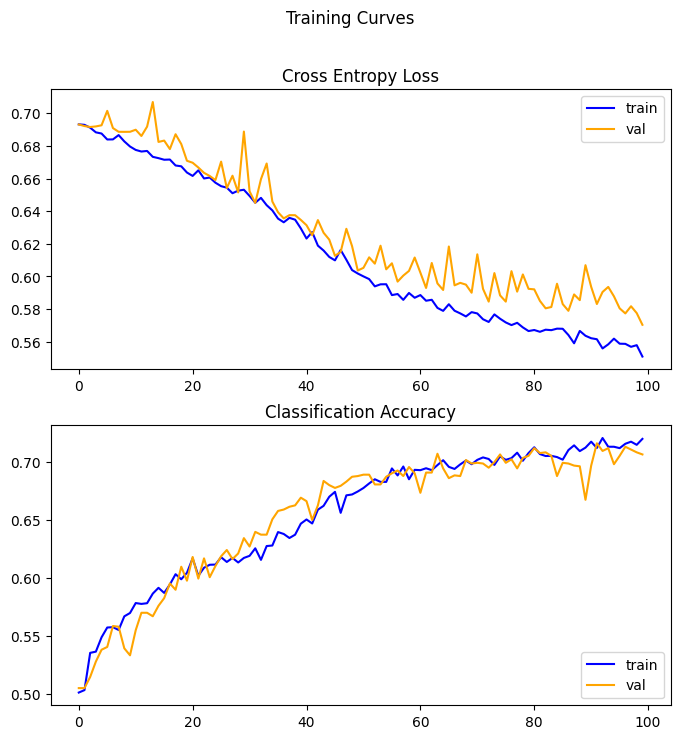

In [ ]:
summarize_diagnostics(history_cnn).show()

We can see that the model continued training throughout all *100* epochs. The training curves develop in parallel, showing no signs of overfitting.

Moving on the evaluation of the model we have:

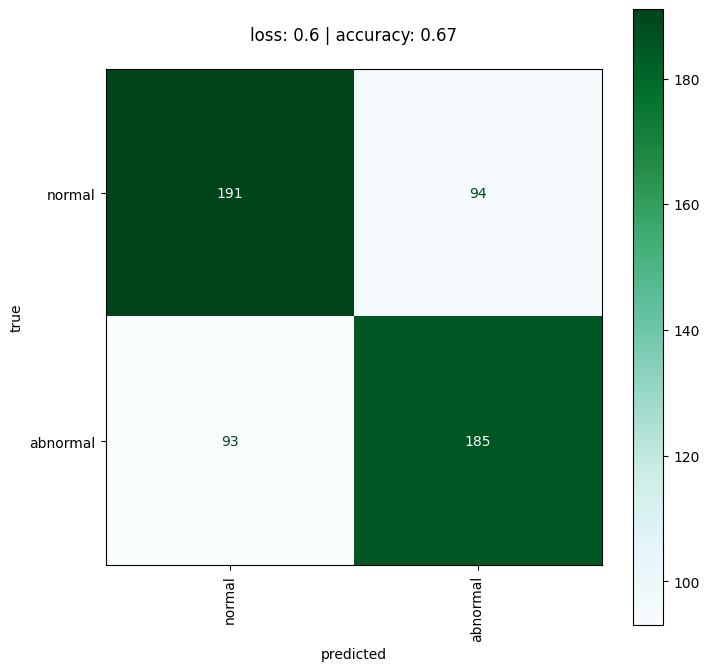

In [ ]:
# predicting and confusion matrix
loss_cnn, accuracy_cnn = cnn.evaluate(test_opt, steps=len(test_images)//BATCH_SIZE, verbose=0)

predict_cnn = cnn.predict(np.asarray(test_images), verbose=0)
predict_cnn_class = predict_cnn > 0.5
predict_cnn_class = predict_cnn_class.astype(int)

conf_matrix = confusion_matrix(test_labels, predict_cnn_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['normal', 'abnormal'])
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='BuGn')
ax.set_title('loss: {} | accuracy: {}\n'.format(round(loss_cnn, 2), round(accuracy_cnn, 2)))
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.xticks(rotation=90)
plt.show()

The model achieves a *67%* accuracy on the test subset.

### Transfer Learning
---

For the transfer learning approach we will utilize `DenseNet201` a network similar to what the creators of the dataset used. The network accepts 3-channel images. Since our dataset is in grayscale, we will create the other 2 dimension by just duplicating the image along the third axis.

Data augmentation was also utilized. Transformations include random rotations and horizontal flips:

In [56]:
# data augmentation
train_images_dnt = np.stack([train_images for i in range(3)], axis=3)
val_images_dnt = np.stack([val_images for i in range(3)], axis=3)
test_images_dnt = np.stack([test_images for i in range(3)], axis=3)

train_images_dnt = train_images_dnt.reshape(len(train_images), 224, 224, 3)

datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)

datagen.fit(train_images_dnt)

The DenseNet's layers were frozen, meaning that no adjusting on the network weights will take place during the training. It is worth noting that we tried unfreezing the last *6* layers. However, signs of overfitting were apparent, while the network performance was not as competitive as what we present in the following cells.

We exclude the output layer of the transfered network, since this was trained on `imagenet` and we only have *2* classes. Before the `sigmoid` activation we add *2* fully-connected layers with a dropout layer inbetween.

As for the callbacks of the network we utilize `EarlyStopping` and `ReduceLROnPlateau`. The latter one will reduce the learning rate of the optimizer by a factor of *20%* whenever the validation loss plateaus for *5* consecutive epochs.

In [57]:
# architecture definition
dnt = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
dnt.trainable = False

tl_model = tf.keras.Sequential([
    dnt,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# compile
tl_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# training
history_tl = tl_model.fit(
    datagen.flow(train_images_dnt, train_labels, batch_size=64),
    epochs=50,
    validation_data=(val_images_dnt, val_labels),
    callbacks = [early_stopping, reduce_lr]
)

Epoch 1/50
105/105 [==============================] - 84s 687ms/step - loss: 0.7354 - accuracy: 0.6084 - val_loss: 0.6017 - val_accuracy: 0.6772 - lr: 1.0000e-04
Epoch 2/50
105/105 [==============================] - 65s 615ms/step - loss: 0.6138 - accuracy: 0.6743 - val_loss: 0.5939 - val_accuracy: 0.7005 - lr: 1.0000e-04
Epoch 3/50
105/105 [==============================] - 65s 622ms/step - loss: 0.5938 - accuracy: 0.6909 - val_loss: 0.5775 - val_accuracy: 0.6826 - lr: 1.0000e-04
Epoch 4/50
105/105 [==============================] - 64s 614ms/step - loss: 0.5691 - accuracy: 0.7100 - val_loss: 0.5485 - val_accuracy: 0.7249 - lr: 1.0000e-04
Epoch 5/50
105/105 [==============================] - 65s 615ms/step - loss: 0.5444 - accuracy: 0.7301 - val_loss: 0.5549 - val_accuracy: 0.7249 - lr: 1.0000e-04
Epoch 6/50
105/105 [==============================] - 65s 620ms/step - loss: 0.5411 - accuracy: 0.7304 - val_loss: 0.5402 - val_accuracy: 0.7345 - lr: 1.0000e-04
Epoch 7/50
105/105 [========

We notice that the training terminates prematurely due to absence of improvement on the validation loss metric.

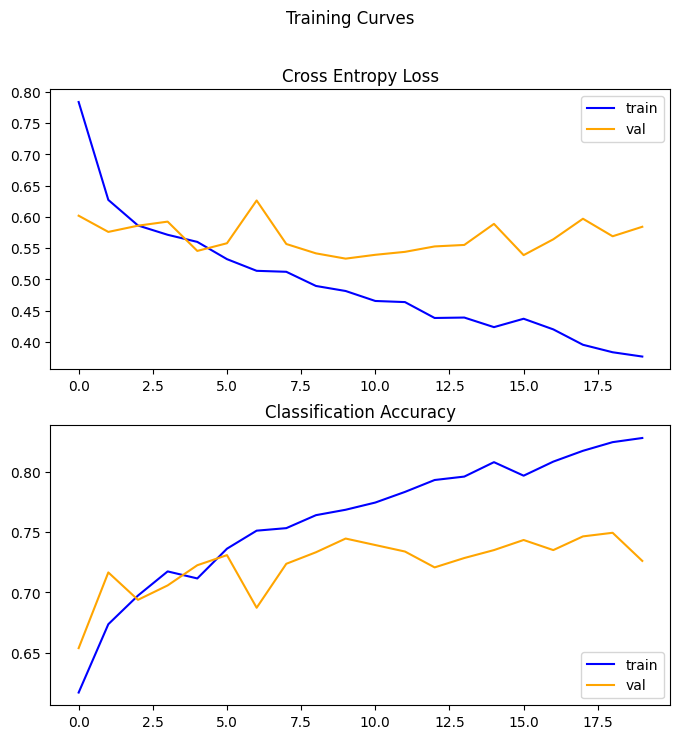

In [46]:
summarize_diagnostics(history_tl).show()

We notice how the learning curve start to noticably deviate from one another during the last epochs of training, indicating signs of overfitting.

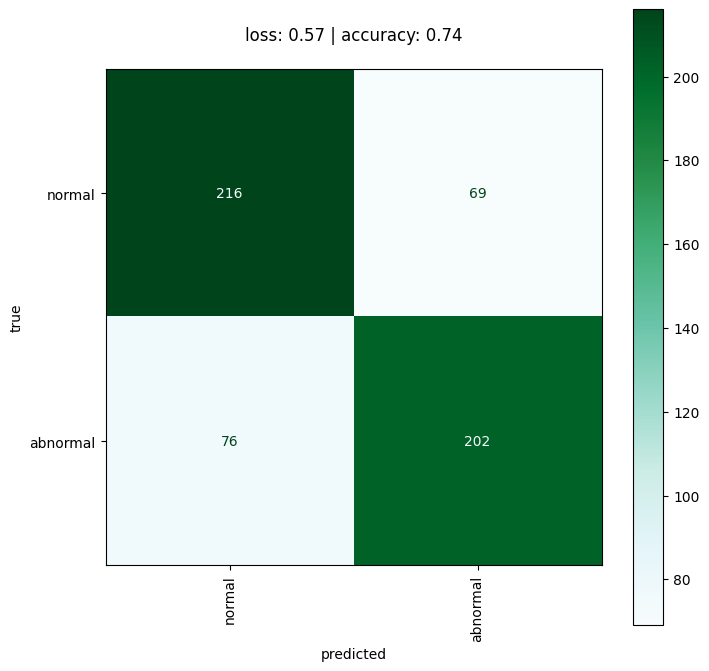

In [59]:
# predicting and confusion matrix
loss_tl, accuracy_tl = tl_model.evaluate(test_images_dnt, test_labels, verbose=0)

predict_tl = tl_model.predict(np.asarray(test_images_dnt), verbose=0)
predict_tl_class = predict_tl > 0.5
predict_tl_class = predict_tl_class.astype(int)

conf_matrix = confusion_matrix(test_labels, predict_tl_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['normal', 'abnormal'])
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='BuGn')
ax.set_title('loss: {} | accuracy: {}\n'.format(round(loss_tl, 2), round(accuracy_tl, 2)))
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.xticks(rotation=90)
plt.show()

The model achieves a better performance compated to our CNN architecture.

## Conclusion & Final Thoughts
---

Two different approaches were followed for the MURA dataset: a CNN architecture and transfer learning using DenseNet201. This notebook was developed solely on shoulder images.

Images for both approaches were augmented with random rotations and horizontal flips. The height and widths of the images were also changed, which turned out to worsen the model's performance.

In terms of overfitting and training, the CNN model showed no relative signs, indicating that the combination of dropout layers and data augmentation were enough. That's not the case for the DenseNet, which displayed early signs of overfitting. The increase of the dropout rate or perhaps the decrease of the hidden layers added before the output one, could prove beneficial for avoiding such behavior.

The transfer learning approach achieved better results than the CNN model with *74%* accuracy and *0.57* loss compared to *67%* accuracy and *0.6* loss. Given the substancial improvement of performance and the similar training times of the networks, the model that utilizes DenseNet can be considered the better of the two.

As long as future steps are concerned, it is worth investingating how the performance of the network alters if we consider different images of a study as a single instance. During this notebook every single image was considered a separate normal or abnormal case. Combining different images from the same study into multiple dimensions could provide the model with insights which it does not currently see. This is actually the approach that the creators of the dataset themselves followed. We note, however, the challenges to this approach, since studies have a varying number of images leading to the creation of an image dataset with a varying third dimension. In order for such case to be addressed one should complement the remaining dimensions by duplicating existing images, similar to what we have done during the transfer learning step.
